# pandas 数据可视化

## 一个简单的案例

某天查看报表数据发现，B端iOS版APP从20180321开始，简历浏览PV翻倍，数据是否正常？

In [2]:
from pyspark.sql import SparkSession, SQLContext, HiveContext
from pyspark import SparkConf, SparkContext
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
spark = SparkSession.builder.appName('tianbin_').enableHiveSupport().getOrCreate()

In [17]:
lpboss=spark.sql("""
select 
p_date,
usere_id,
view_datetime,
view_id
from dw_b_d_res_view_detail
where p_date between 20180101 and 20180610
and device_type=2
""").toPandas()

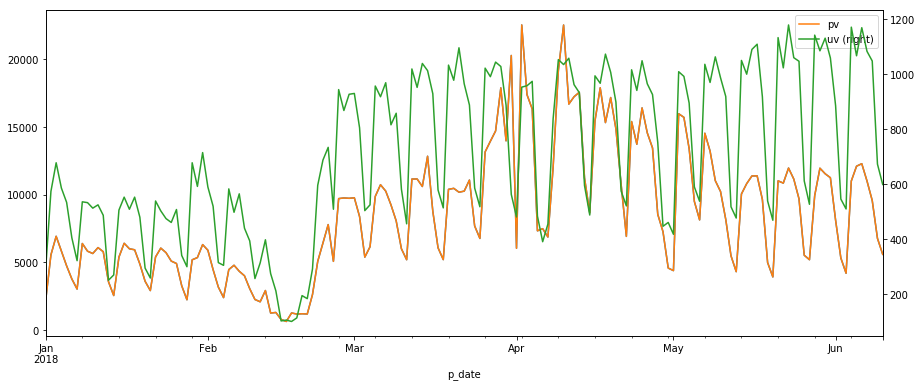

In [22]:
# 查看数据基本情况,pv,uv
lpboss['p_date']=pd.to_datetime(lpboss['p_date'],format='%Y%m%d')
# lpboss.head(5)
lpboss.groupby('p_date').view_id.size().plot(figsize=[15,6])
lpboss_agg=lpboss.groupby('p_date').agg({'view_id':np.size,'usere_id':pd.Series.nunique}).rename(columns={'view_id':'pv','usere_id':'uv'})
# lpboss_agg.plot(figsize=[15,6])
lpboss_agg.pv.plot(legend=True)
lpboss_agg.uv.plot(secondary_y=True,legend=True)

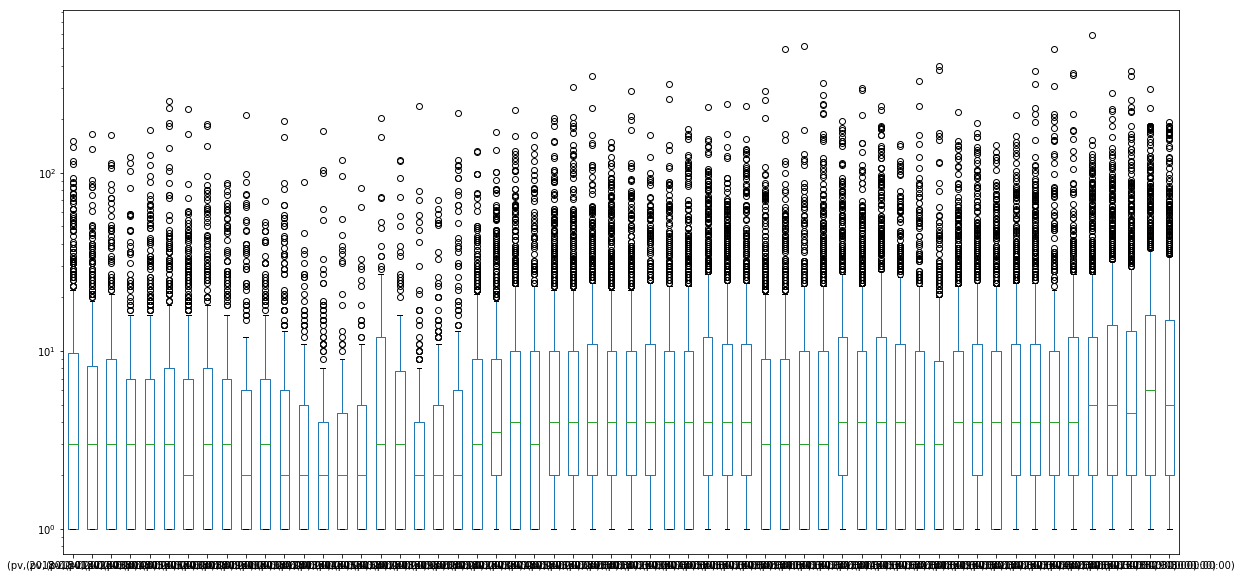

In [19]:
# 定位异常用户,浏览PV绘制箱线图
plt.figure()
lpboss_agg=lpboss.groupby(['p_date','usere_id']).agg({'view_id':np.size}).rename(columns={'view_id':'pv'})
bx=pd.pivot_table(lpboss_agg.loc['2018-02-01':'2018-03-30'],index=['usere_id'],columns=['p_date'])
bx.head(5)
# bx.plot.box()
# x轴显示待优化 pd.date_range('2018-02-01',freq='D',periods=58)
bx.plot.box(figsize=[20,10],logy=True)

In [50]:
#每分钟平均浏览简历数绘制箱线图
# lpboss_pv=lpboss.groupby(['p_date','usere_id']).agg({'view_id':np.size,'view_datetime':(np.min,np.max)})
lpboss.view_datetime=pd.to_datetime(lpboss.view_datetime)
lpboss_pv=lpboss.groupby(['p_date','usere_id']).agg({'view_id':np.size,'view_datetime':(lambda x: (np.max(x)-np.min(x)))})
lpboss_pv.head(5)

view_datetime  view_id
p_date     usere_id                       
2018-01-01 207663        00:27:22        3
           1033736       00:01:30        4
           1746605       00:00:36        3
           1999284       00:00:00        1
           2233424       00:00:00        1

In [44]:
lpboss_pv.timediff=lpboss_pv.view_datetime.amin-lpboss_pv.view_datetime.amin

TypeError: unsupported operand type(s) for -: 'unicode' and 'unicode'

## 基础图形绘制

pandas 通过对matplotlib的封装，实现了基础的图形绘制工具，可以更简便的利用 Series 和 DataFrame 的数据结构进行数据可视化

 - Series.plot()
 - DataFrame.plot()

### line plots

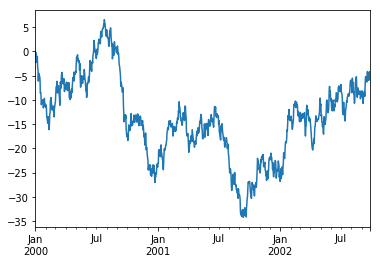

In [6]:
#1.调用plot()默认生成线型图，并以Series或DataFrame的index作为x轴
#2.如果index为时间格式，plot会尝试对时间的展示格式进行自动调整
#官方文档示例
ts = pd.Series(np.random.randn(1000),index=pd.date_range('1/1/2000',periods=1000))
ts = ts.cumsum()
ts.plot()

In [7]:
#数据集概览
dtl=spark.sql("""
select p_date,
usere_id,
device_type,
sfrom,
report_business_type,
save_click_cnt,
communicate_click_cnt,
download_click_cnt,
intention_click_cnt,
pv
from jupyter.temp_tianbin_jupyter_visualization_dataset
""").toPandas()

In [8]:
# 绘制简历浏览量和下载量的趋势图
dtl['p_date']=pd.to_datetime(dtl['p_date'],format='%Y%m%d')
dtl=dtl.set_index('p_date')
dtl_sum = dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','save_click_cnt'].sum()
dtl.head(5)
dtl_sum.head(5)

,pv,download_click_cnt,intention_click_cnt,save_click_cnt
p_date,,,,
2018-05-01,65923,2118,78,3599
2018-05-02,848350,28305,1977,59594
2018-05-03,831224,32634,2407,64037
2018-05-04,688709,28667,1993,53688
2018-05-05,157708,6574,343,10338


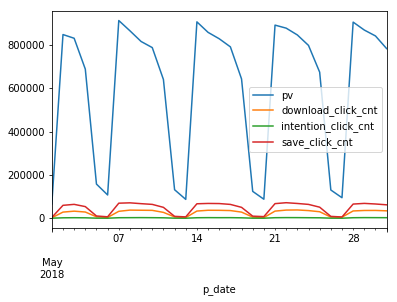

In [9]:
# polt()对每列绘制图像并生成标注
dtl_sum.plot()

### bar plots

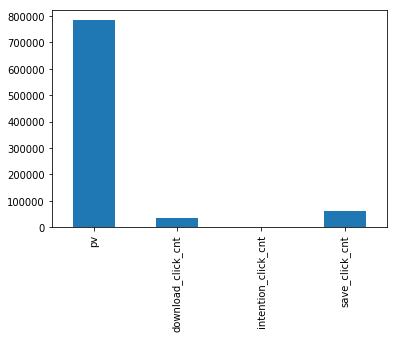

In [10]:
#待优化
dtl_sum.loc['2018-05-31'].plot.bar()

### box plots

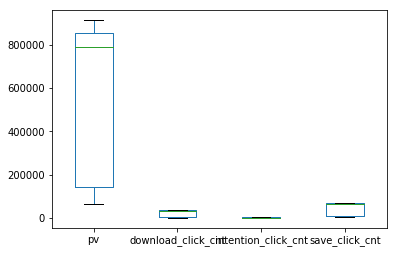

In [186]:
dtl_sum.plot.box()

### area plot

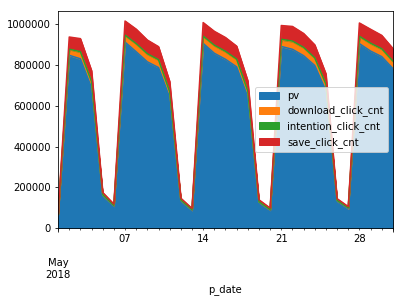

In [189]:
dtl_sum.plot.area()

### scatter plot

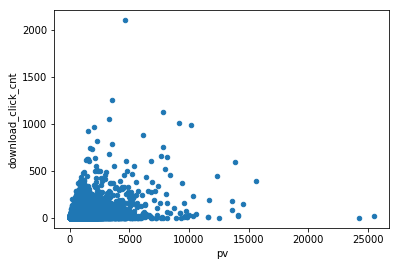

In [45]:
dtl.groupby('usere_id').sum().plot.scatter(x='pv',y='download_click_cnt')

### pie plot

In [46]:
# dtl_sum.plot.pie()

## 进阶图形绘制

### 参数控制 

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

#### style:线型和颜色

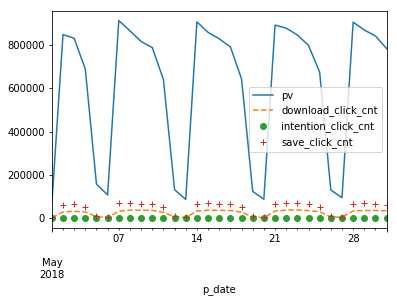

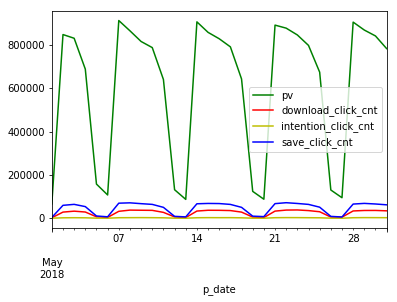

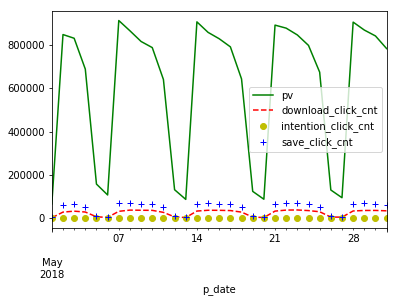

In [191]:
# 使用style参数控制线型和颜色
dtl_sum.plot(style=['-','--','o','+'])
dtl_sum.plot(style=['g','r','y','b'])
dtl_sum.plot(style=['-g','--r','oy','+b'])

#### colormap:颜色组合方案
 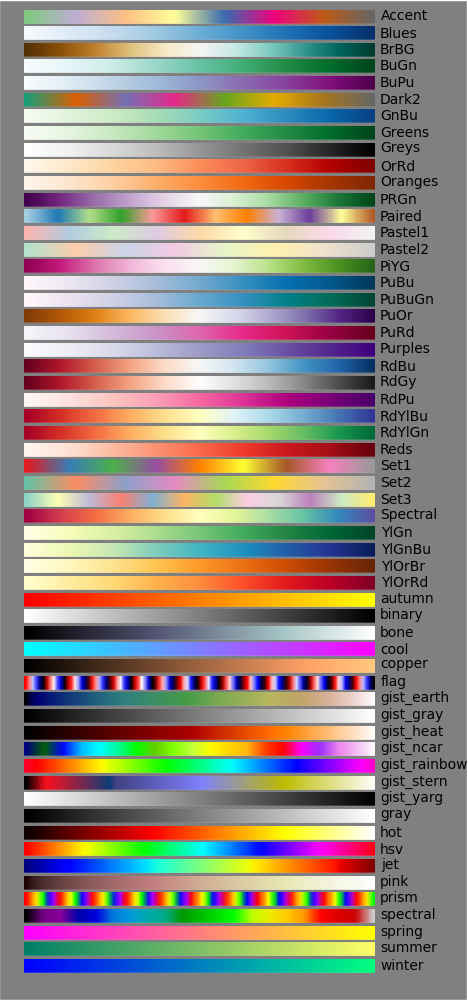

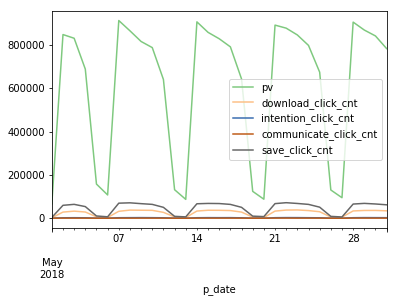

In [193]:
dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','communicate_click_cnt','save_click_cnt'].sum().plot(colormap='Accent')

#### legend:图例

In [166]:
#使用legend控制图例
# dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','communicate_click_cnt'].sum().plot()
# dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','communicate_click_cnt'].sum().plot(legend=False)
# dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','communicate_click_cnt'].sum().plot().legend(loc='upper right', frameon=False)

#### logy：对数坐标

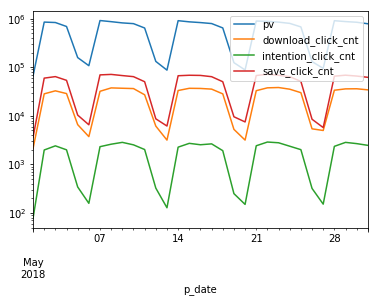

In [211]:
#对数坐标
dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','save_click_cnt'].sum().plot(logy=True).legend(loc='upper right')

#### secondary_y:双Y轴

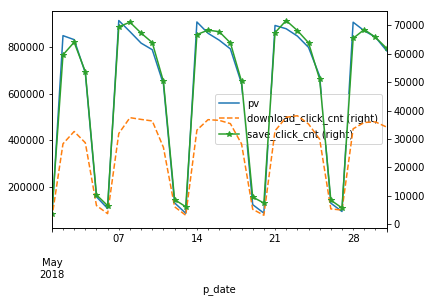

In [213]:
dtl.groupby('p_date')['pv'].sum().plot(legend=True)
dtl.groupby('p_date')['download_click_cnt'].sum().plot(secondary_y=True,style='--',legend=True)
dtl.groupby('p_date')['save_click_cnt'].sum().plot(secondary_y=True,style='-*',legend=True)

#### subplots 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2adc19ec0f10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2adc1bd3d190>], dtype=object)

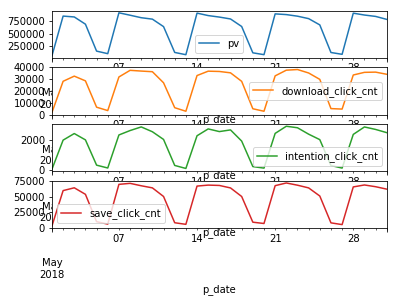

In [52]:
dtl.groupby('p_date')['pv','download_click_cnt','intention_click_cnt','save_click_cnt'].sum().plot(subplots=True,sharex=False)

### 缺失值处理
Plot Type | NaN Handling
--- | ---
Line | Leave gaps at NaNs
Line(stacked) | Fill 0's
Bar | Fill 0's
Scatter | Drop NaNs
Histogram | Drop NaNs(column-wise)
Box | Drop NaNs(column-wise)
Area | Fill 0's
KDE | Drop NaNs(column-wise)
Hexbin |  Drop NaNs
Pie | Fill 0's